# Optics calculation and matching for a large ring (LHC)

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import numpy as np
import matplotlib.pyplot as plt

### Load LHC model

In [3]:
collider = xt.Multiline.from_json(
    "../../xtrack/test_data/hllhc15_thick/hllhc15_collider_thick.json")
collider.vars.load_madx_optics_file(
    "../../xtrack/test_data/hllhc15_thick/opt_round_150_1500.madx")

collider.build_trackers()

Loading line from dict:   0%|          | 0/30281 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/30289 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


### Initial twiss

In [4]:
tw0 = collider.lhcb1.twiss()

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [5]:
# Inspect IPS
tw0.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name                        betx    bety     mux     muy            x            y
ip1                         0.15    0.15       0       0            0            0
ip2                           10      10 8.23376  7.6927 -1.63469e-17  4.71381e-35
ip3                      121.567 218.584 15.9494 15.4503  5.97025e-16 -4.06658e-35
ip4                       236.18 306.197  23.507 22.3832 -3.23008e-16 -1.53498e-34
ip5                         0.15    0.15 30.9305 29.9889   6.3932e-18 -3.92269e-37
ip6                      273.434  183.74 38.7487 37.3936  3.57142e-16 -1.07316e-34
ip7                      120.813 149.431 46.3524 44.5934 -1.89169e-16  1.25637e-34
ip8                          1.5     1.5 54.3432 52.2729 -1.99753e-17  4.20716e-33
ip1.l1                      0.15    0.15   62.31   60.32  -9.6474e-19 -3.51936e-34

### Prepare for optics matching: set limits and steps for all circuits

In [6]:
import lhc_match as lm
lm.set_var_limits_and_steps(collider)

In [7]:
# Inspect for one circuit
collider.vars.vary_default['kq4.l2b2']

{'step': 1e-06, 'limits': (0.00020557714282348692, 0.0068525714274495645)}

### Twiss on a part of the machine (bidirectional)

In [8]:
tw_81_12 = collider.lhcb1.twiss(start='ip8', end='ip2', init_at='ip1',
                                betx=0.15, bety=0.15)

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_backtrack_frozen_energy`.


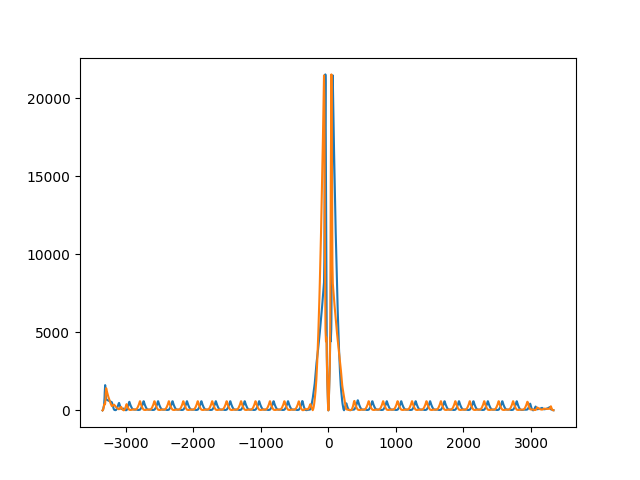

In [9]:
plt.figure()
plt.plot(tw_81_12.s, tw_81_12.betx)
plt.plot(tw_81_12.s, tw_81_12.bety)

### Telescopic rematch of IP1 using IP2 and IP8

#### Match left side

In [10]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='s.ds.l8.b1', end='ip1',
    init=tw0, init_at=xt.START,
    vary=[
        # Only IR8 quadrupoles including DS
        xt.VaryList(['kq6.l8b1', 'kq7.l8b1', 'kq8.l8b1', 'kq9.l8b1', 'kq10.l8b1', 
            'kqtl11.l8b1', 'kqt12.l8b1', 'kqt13.l8b1',
            'kq4.l8b1', 'kq5.l8b1', 'kq4.r8b1', 'kq5.r8b1', 
            'kq6.r8b1', 'kq7.r8b1', 'kq8.r8b1', 'kq9.r8b1', 
            'kq10.r8b1', 'kqtl11.r8b1', 'kqt12.r8b1', 'kqt13.r8b1'])],
    targets=[
        xt.TargetSet(at='ip8', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetSet(at='ip1', betx=0.15, bety=0.10, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'ip1.l1'] - tw0['mux', 's.ds.l8.b1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'ip1.l1'] - tw0['muy', 's.ds.l8.b1']), 
    ])

In [11]:
opt.target_status()

Target status:                          
id state tag tol_met      residue  current_val  target_val description                                 
 0 ON           True -4.31821e-10          1.5         1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
 1 ON           True -5.73956e-11          1.5         1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
 2 ON           True -3.28082e-11  2.21564e-07 2.21597e-07 line=lhcb1, ('alfx', 'ip8'), val=2.21597 ...
 3 ON           True  1.86084e-12  2.15516e-07 2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
 4 ON           True  8.52321e-10  1.87664e-09 1.02432e-09 line=lhcb1, ('dx', 'ip8'), val=1.02432e- ...
 5 ON           True   9.1681e-10  1.11905e-09 2.02244e-10 line=lhcb1, ('dpx', 'ip8'), val=2.02244e ...
 6 ON           True -5.34787e-08         0.15        0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
 7 ON          False         0.05         0.15         0.1 line=lhcb1, ('bety', 'ip1'), val=0.1, to ...
 8 ON           True  4

In [12]:
opt.step(40)

In [13]:
opt.target_status()

Target status:                            
id state tag tol_met      residue  current_val  target_val description                                 
 0 ON           True -2.92252e-10          1.5         1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
 1 ON           True  2.09428e-09          1.5         1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
 2 ON           True  6.53595e-11  2.21662e-07 2.21597e-07 line=lhcb1, ('alfx', 'ip8'), val=2.21597 ...
 3 ON           True  1.88142e-11  2.15533e-07 2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
 4 ON           True -2.17642e-10  8.06674e-10 1.02432e-09 line=lhcb1, ('dx', 'ip8'), val=1.02432e- ...
 5 ON           True -1.36586e-10  6.56586e-11 2.02244e-10 line=lhcb1, ('dpx', 'ip8'), val=2.02244e ...
 6 ON           True  2.95796e-10         0.15        0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
 7 ON           True -4.35266e-11          0.1         0.1 line=lhcb1, ('bety', 'ip1'), val=0.1, to ...
 8 ON           True 

#### Match right side

In [14]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='ip1', end='e.ds.r2.b1',
    init=tw0, init_at=xt.END, # <-- We match going backward in the line
    vary=[
        xt.VaryList([
            'kq9.l2b1', 'kq10.l2b1', 'kqtl11.l2b1', 'kqt12.l2b1', 'kqt13.l2b1',
            'kq9.r2b1', 'kq10.r2b1', 'kqtl11.r2b1', 'kqt12.r2b1', 'kqt13.r2b1',
            'kq4.l2b1', 'kq5.l2b1',  'kq6.l2b1', 'kq7.l2b1', 'kq8.l2b1',
            'kq6.r2b1',  'kq7.r2b1', 'kq8.r2b1', 'kq4.r2b1', 'kq5.r2b1'])],
    targets=[
        # Only IR2 quadrupoles including DS
        xt.TargetSet(at='ip1', betx=0.15, bety=0.10, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetSet(at='ip2', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'e.ds.r2.b1'] - tw0['mux', 'ip1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'e.ds.r2.b1'] - tw0['muy', 'ip1']),
    ])

In [15]:
opt.step(20)

In [16]:
opt.target_status()

Target status:                            
id state tag tol_met      residue  current_val  target_val description                                 
 0 ON           True  8.97557e-11         0.15        0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
 1 ON           True  -1.0201e-10          0.1         0.1 line=lhcb1, ('bety', 'ip1'), val=0.1, to ...
 2 ON           True -7.63894e-10 -7.63894e-10           0 line=lhcb1, ('alfx', 'ip1'), val=0, tol= ...
 3 ON           True  6.42791e-11  6.42791e-11           0 line=lhcb1, ('alfy', 'ip1'), val=0, tol= ...
 4 ON           True -1.08909e-10 -1.08909e-10           0 line=lhcb1, ('dx', 'ip1'), val=0, tol=1e ...
 5 ON           True -2.11459e-10 -2.11459e-10           0 line=lhcb1, ('dpx', 'ip1'), val=0, tol=1 ...
 6 ON           True -4.33694e-10           10          10 line=lhcb1, ('betx', 'ip2'), val=10, tol ...
 7 ON           True  1.68868e-10           10          10 line=lhcb1, ('bety', 'ip2'), val=10, tol ...
 8 ON           True 

#### Inspect results

In [17]:
tw_new = collider.lhcb1.twiss()

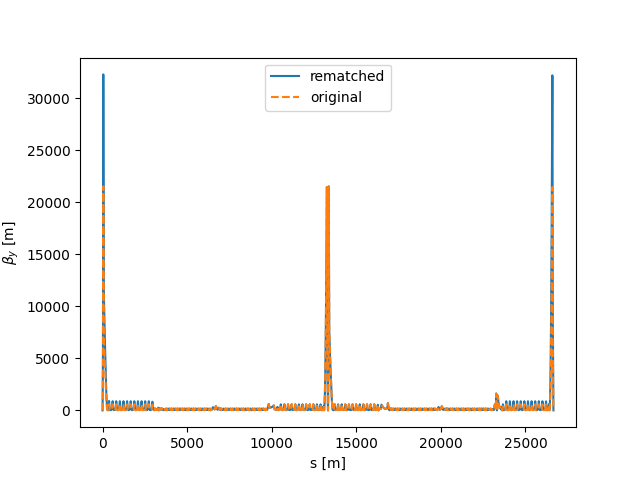

In [21]:
plt.figure()
plt.plot(tw_new.s, tw_new.bety, label='rematched')
plt.plot(tw0.s, tw0.bety, '--', label='original')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_y$ [m]')
plt.legend()

In [23]:
# Inspect table
tw_new.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name                        betx      bety     mux     muy            x            y
ip1                         0.15       0.1       0       0            0            0
ip2                           10        10 8.24225 7.69298 -1.40156e-17  4.85302e-35
ip3                      121.567   218.584 15.9494 15.4503  4.19893e-16 -2.44479e-34
ip4                       236.18   306.196  23.507 22.3832  5.93845e-17 -3.75665e-34
ip5                         0.15      0.15 30.9305 29.9889  6.37071e-19  4.76367e-36
ip6                      273.434   183.739 38.7487 37.3936  7.93624e-16 -2.83796e-34
ip7                      120.813   149.431 46.3524 44.5934 -5.66595e-16   2.3523e-35
ip8                          1.5       1.5 54.3426 52.2588 -7.97922e-17  -4.8189e-34
ip1.l1                      0.15 0.0999999   62.31   60.32 -3.50524e-17 -3.26958e-36

# MAD-NG interface

### Get MAD-NG model from Xsuite
We can easily generate the corresponding MAD-NG model ([pymadng](https://pymadng.readthedocs.io/en/latest/) used under the hood)

In [25]:
mng = collider.lhcb1.to_madng(sequence_name='lhcb1')

### Use MAD-NG TPSA to compute octupolar RDTs

In [28]:
mng.send('''
    local damap in MAD
    local lhc = MADX.lhcb1
    
    -- list of octupolar RDTs
    local rdts = {"f4000", "f3100", "f2020", "f1120"}
    
    -- create phase-space damap at 4th order
    local X0 = damap {nv=6, mo=4}
    
    -- twiss with RDTs
    local mtbl = twiss {sequence=lhc, X0=X0, trkrdt=rdts, info=2, saverdt=true}
    
    -- send columns to Python
    py:send({mtbl.s, mtbl.beta22, mtbl.f4000, mtbl.f3100, mtbl.f2020, mtbl.f1120})

''')

s, beta22, f4000, f3100, f2020, f1120 = mng.recv()

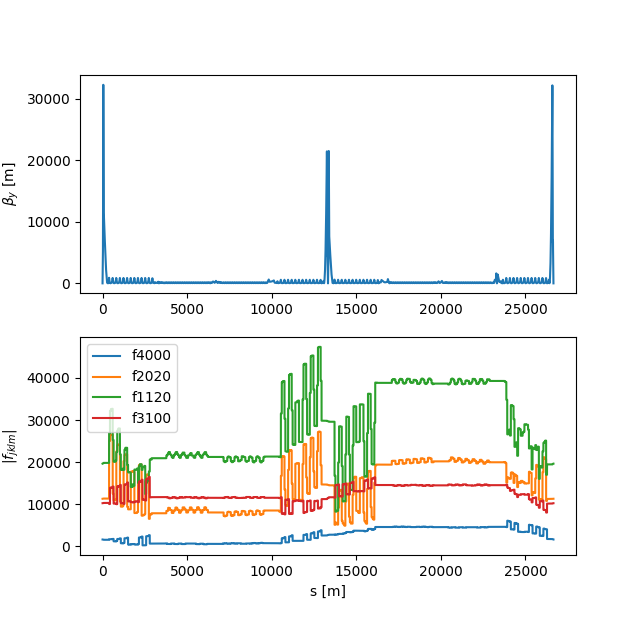

In [37]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(2,1,1)
ax1.plot(s, beta22)
plt.ylabel(r'$\beta_y$ [m]')

ax2 = plt.subplot(2,1,2)
plt.plot(s, np.abs(f4000), label='f4000')
plt.plot(s, np.abs(f2020), label='f2020')
plt.plot(s, np.abs(f1120), label='f1120')
plt.plot(s, np.abs(f3100), label='f3100')
plt.xlabel('s [m]')
plt.ylabel(r'|$f_{jklm}$|')
plt.legend()
plt.sub